In this notebook we use GCN to analyze the POIs networks

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd drive/MyDrive/Colab\ Notebooks

/content/drive/MyDrive/Colab Notebooks


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import keras
from keras.layers import Dense
from keras.models import Sequential
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import torchtext
import torch
from torch.nn import Linear
from torch_geometric.nn import GCNConv
import torch_geometric
import itertools
import nltk
import spacy
import random
from tqdm import tqdm
import time
from IPython.display import Javascript

In [ ]:
import numpy as np
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import math
from collections import Counter
import random
import csv
import os
import sys

In [ ]:
random.seed(10)

In [ ]:
df = pd.read_csv('./datasets/gentrification_labels.csv')

In [ ]:
df.tail(10)

,GEOID,label,the_geom,STATEFP10,COUNTYFP10,TRACTCE10,NAME10,NAMELSAD10,INTPTLAT,INTPTLONG,long+,long-,lat+,lat-
791,17031843200,1,MULTIPOLYGON (((-87.65045099997508 41.85258499...,17,31,843200,8432.0,Census Tract 8432,41.848715,-87.664217,-87.660597,-87.667837,41.851420,41.846010
792,17031843300,1,MULTIPOLYGON (((-87.68821699998962 41.85933700...,17,31,843300,8433.0,Census Tract 8433,41.863764,-87.692550,-87.688930,-87.696170,41.866469,41.861059
793,17031843400,1,MULTIPOLYGON (((-87.72356499996559 41.85156999...,17,31,843400,8434.0,Census Tract 8434,41.849327,-87.732022,-87.728402,-87.735642,41.852032,41.846622
794,17031843500,1,MULTIPOLYGON (((-87.6927909999821 41.844721999...,17,31,843500,8435.0,Census Tract 8435,41.840983,-87.697566,-87.693946,-87.701186,41.843688,41.838278
795,17031843600,0,MULTIPOLYGON (((-87.61128600000754 41.80216899...,17,31,843600,8436.0,Census Tract 8436,41.806765,-87.608949,-87.605329,-87.612569,41.809470,41.804060
796,17031843700,0,MULTIPOLYGON (((-87.69666899996376 41.94854100...,17,31,843700,8437.0,Census Tract 8437,41.945560,-87.690034,-87.686414,-87.693654,41.948265,41.942855
797,17031843800,0,MULTIPOLYGON (((-87.6451599999826 41.794302000...,17,31,843800,8438.0,Census Tract 8438,41.801657,-87.640476,-87.636856,-87.644096,41.804362,41.798952
798,17031843900,0,MULTIPOLYGON (((-87.55868599996295 41.77379199...,17,31,843900,8439.0,Census Tract 8439,41.778993,-87.576130,-87.572510,-87.579750,41.781698,41.776288
799,17031980000,0,MULTIPOLYGON (((-87.92062799997296 42.00453199...,17,31,980000,9800.0,Census Tract 9800,41.979419,-87.902438,-87.898818,-87.906058,41.982124,41.976714
800,17031980100,0,MULTIPOLYGON (((-87.73789600001243 41.78578500...,17,31,980100,9801.0,Census Tract 9801,41.785981,-87.750900,-87.747280,-87.754520,41.788686,41.783276


In [ ]:
ids = df['GEOID']
labels = df['label']
lats = df['INTPTLAT']
longs = df['INTPTLONG']

In [ ]:
chi_lat_n = 42.05
chi_lat_s = 41.7
chi_long_w = -87.9
chi_long_e = -87.53

In [ ]:
tracts = pd.DataFrame(list(zip(ids, lats, longs, labels)))
tracts.columns = ['id', 'lat', 'long', 'label']

In [ ]:
tracts.describe()

,id,lat,long,label
count,8.010000e+02,801.000000,801.000000,801.000000
mean,1.703141e+10,41.859390,-87.677877,0.197253
std,2.779699e+05,0.089801,0.059513,0.398174
min,1.703101e+10,41.650720,-87.907497,0.000000
25%,1.703116e+10,41.783596,-87.715068,0.000000
50%,1.703135e+10,41.871619,-87.673322,0.000000
75%,1.703167e+10,41.935114,-87.638807,0.000000
max,1.703198e+10,42.021256,-87.529432,1.000000


In [ ]:
tracts.tail(10)

,id,lat,long,label
791,17031843200,41.848715,-87.664217,1
792,17031843300,41.863764,-87.692550,1
793,17031843400,41.849327,-87.732022,1
794,17031843500,41.840983,-87.697566,1
795,17031843600,41.806765,-87.608949,0
796,17031843700,41.945560,-87.690034,0
797,17031843800,41.801657,-87.640476,0
798,17031843900,41.778993,-87.576130,0
799,17031980000,41.979419,-87.902438,0
800,17031980100,41.785981,-87.750900,0


In [ ]:
for index, row in tracts.iterrows():
    if (row['lat'] > chi_lat_n or row['lat'] < chi_lat_s or
            row['long'] > chi_long_e or row['long'] < chi_long_w):
        tracts = tracts.drop([index])

In [ ]:
city_graph = nx.Graph()
color_map = []
for index, row in tracts.iterrows():
    city_graph.add_node((row['long'], row['lat']),
                        pos=(row['long'], row['lat']),
                        label=row['label'])
    if row['label'] == 1:
        color_map.append('purple')
    else:
        color_map.append('lightblue')

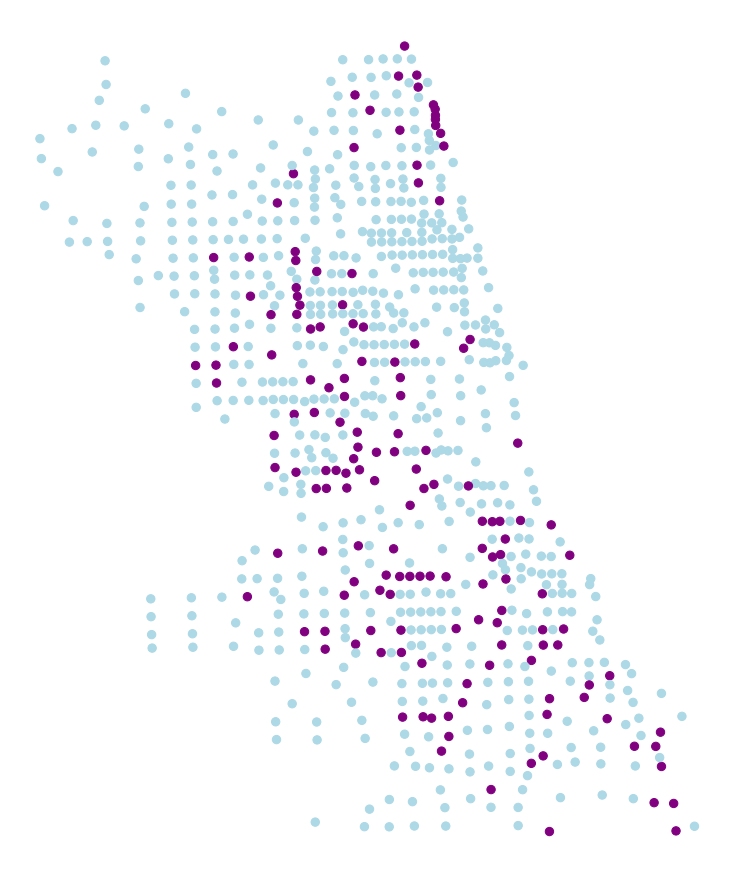

In [ ]:
plt.figure(figsize=(10, 12))

pos=nx.get_node_attributes(city_graph,'pos')
nx.draw(city_graph, pos=pos,
        node_color=color_map, 
        with_labels=False,
        node_size=70)

In [ ]:
pip install pykml

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 41 kB 154 kB/s 


In [ ]:
from pykml import parser

In [ ]:
h_lat_n = 42.05
h_lat_s = 41.7
h_long_w = -87.82
h_long_e = -87.53

In [ ]:
def get_distance(p1, p2):
    dist = math.sqrt((p1[0]-p2[0])**2 + (p1[1]-p2[1])**2)
    return dist

In [ ]:
filepath = './datasets/kmlHospitals.kml'
with open(filepath) as fobj:
    folder = parser.parse(fobj).getroot().Document.Folder

hospitals = []
for pm in folder.Placemark:
    coordinates = pm.Point.coordinates
    longitude = float(str(coordinates)[0:11])
    latitude = float(str(coordinates)[12:21])
    if ((latitude > h_lat_s and latitude < h_lat_n) and
            (longitude > h_long_w and longitude < h_long_e)):
        hospitals.append([longitude, latitude, 0])

In [ ]:
for i, hospital in enumerate(hospitals):
    closest_distance = 1000000
    for index, row in tracts.iterrows():
        dist = get_distance((row['long'], row['lat']),
                            (hospital[0], hospital[1]))
        if dist < closest_distance:
            closest_distance = dist
            label = row['label']
    hospitals[i][2] = int(label)

In [ ]:
filepath = './datasets/CTA_RailStations.kml'
with open(filepath) as fobj:
    folder = parser.parse(fobj).getroot().Document.Folder

cta = []
for pm in folder.Placemark:
    coordinates = str(pm.Point.coordinates).split(',')
    longitude = float(coordinates[0])
    latitude = float(coordinates[1])
    if ((latitude > h_lat_s and latitude < h_lat_n) and
            (longitude > h_long_w and longitude < h_long_e)):
        cta.append([longitude, latitude, 0])

In [ ]:
for i, station in enumerate(cta):
    closest_distance = 1000000
    for index, row in tracts.iterrows():
        dist = get_distance((row['long'], row['lat']),
                            (station[0], station[1]))
        if dist < closest_distance:
            closest_distance = dist
            label = row['label']
    cta[i][2] = int(label)

In [ ]:
filepath = './datasets/kmlPrivateSchools.kml'
with open(filepath) as fobj:
    folder = parser.parse(fobj).getroot().Document.Folder

private_schools = []
for pm in folder.Placemark:
    coordinates = pm.Point.coordinates
    longitude = float(str(coordinates)[0:11])
    latitude = float(str(coordinates)[12:21])
    if ((latitude > h_lat_s and latitude < h_lat_n) and
            (longitude > h_long_w and longitude < h_long_e)):
        private_schools.append([longitude, latitude, 0])

In [ ]:
filepath = './datasets/kmlPublicSchools.kml'
with open(filepath) as fobj:
    folder = parser.parse(fobj).getroot().Document.Folder

public_schools = []
for pm in folder.Placemark:
    coordinates = pm.Point.coordinates
    longitude = float(str(coordinates)[0:11])
    latitude = float(str(coordinates)[12:21])
    if ((latitude > h_lat_s and latitude < h_lat_n) and
            (longitude > h_long_w and longitude < h_long_e)):
        public_schools.append([longitude, latitude, 0])

In [ ]:
all_schools = public_schools + private_schools

In [ ]:
for i, school in enumerate(all_schools):
    closest_distance = 1000000
    for index, row in tracts.iterrows():
        dist = get_distance((row['long'], row['lat']),
                            (school[0], school[1]))
        if dist < closest_distance:
            closest_distance = dist
            label = row['label']
    all_schools[i][2] = int(label)

In [ ]:
tract_lats = tracts['lat'].tolist()
tract_longs = tracts['long'].tolist()
tract_labels = tracts['label'].tolist()

In [ ]:
# Remove the components you are interested in seeing
all_nodes = list(zip(tract_longs, tract_lats, tract_labels)) + hospitals + cta + all_schools

In [ ]:
tract_indices = list(range(0, len(tracts)))
all_indices = list(range(0, len(all_nodes)))
hospital_indices = list(range(len(tracts), len(tracts) + len(hospitals)))
cta_indices = list(range(len(tracts) + len(hospitals), len(tracts) + len(hospitals) + len(cta)))
school_indices = list(range(len(tracts) + len(hospitals) + len(cta), len(tracts) + len(hospitals) + len(cta) + len(all_schools)))

In [ ]:
len(hospitals), len(hospital_indices)

(48, 48)

In [ ]:
# Creating a graph using NetworkX

# Adding nodes
city_graph = nx.Graph()
color_map = []
for i, values in enumerate(all_nodes):
    n_long, n_lat, n_label = values
    city_graph.add_node(i,
                        pos=(n_long, n_lat),
                        econ=[0,1,2,3])
    
    if n_label == 1:
         color_map.append('purple')
    else:
        color_map.append('lightblue')

# Adding edges
# To observe only one of the networks comment out the unwanted sections
for tract_i in all_indices:
    hospital_dict = {}
    for hospital_i in hospital_indices:
        hospital_dict[hospital_i] = get_distance((all_nodes[hospital_i][0], all_nodes[hospital_i][1]),
                                             (all_nodes[tract_i][0], all_nodes[tract_i][1]))
    
    closest2 = sorted(hospital_dict, key=hospital_dict.get, reverse=False)[0:2]
    
    for i in closest2:
        s_lat = all_nodes[i][1]
        s_long = all_nodes[i][0]
        distance = get_distance((all_nodes[tract_i][0], all_nodes[tract_i][1]),
                                (s_long, s_lat))
        city_graph.add_edge(tract_i, i, weight=distance)
        # city_graph.add_edge(tract_i, i)

for tract_i in all_indices:
    school_dict = {}
    for school_i in school_indices:
        school_dict[school_i] = get_distance((all_nodes[school_i][0], all_nodes[school_i][1]),
                                             (all_nodes[tract_i][0], all_nodes[tract_i][1]))
    
    closest2 = sorted(school_dict, key=school_dict.get, reverse=False)[0:2]
    
    for i in closest2:
        s_lat = all_nodes[i][1]
        s_long = all_nodes[i][0]
        distance = get_distance((all_nodes[tract_i][0], all_nodes[tract_i][1]),
                                (s_long, s_lat))
        city_graph.add_edge(tract_i, i, weight=distance)
        # city_graph.add_edge(tract_i, i)

for tract_i in all_indices:
    cta_dict = {}
    for cta_i in cta_indices:
        cta_dict[cta_i] = get_distance((all_nodes[cta_i][0], all_nodes[cta_i][1]),
                                             (all_nodes[tract_i][0], all_nodes[tract_i][1]))
    
    closest2 = sorted(cta_dict, key=cta_dict.get, reverse=False)[0:2]
    
    for i in closest2:
        s_lat = all_nodes[i][1]
        s_long = all_nodes[i][0]
        distance = get_distance((all_nodes[tract_i][0], all_nodes[tract_i][1]),
                                (s_long, s_lat))
        city_graph.add_edge(tract_i, i, weight=distance)
        # city_graph.add_edge(tract_i, i)

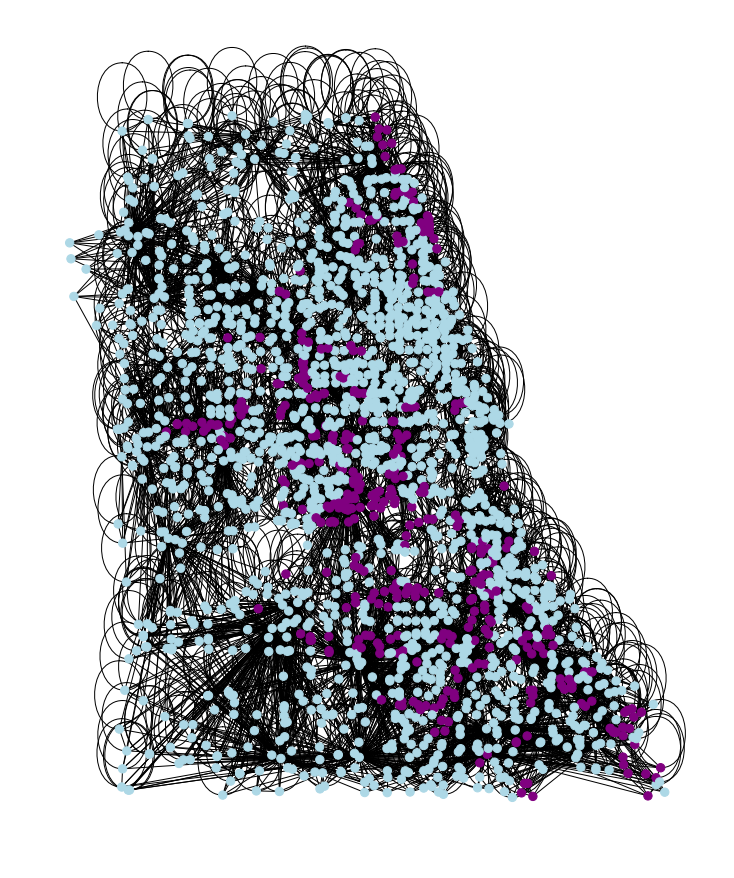

In [ ]:
plt.figure(figsize=(10, 12))

pos=nx.get_node_attributes(city_graph,'pos')
nx.draw(city_graph, pos=pos,
        node_color=color_map, 
        with_labels=False,
        node_size=70)

In [ ]:
def from_networkx(G):
    G = nx.convert_node_labels_to_integers(G)
    edge_index = torch.LongTensor(list(G.edges)).t().contiguous()
    data = {}
    for i, (_, feat_dict) in enumerate(G.nodes(data=True)):
        for key, value in feat_dict.items():
            data[str(key)] = [value] if i == 0 else data[str(key)] + [value]

    for i, (_, _, feat_dict) in enumerate(G.edges(data=True)):
        for key, value in feat_dict.items():
            data[str(key)] = [value] if i == 0 else data[str(key)] + [value]

    for key, item in data.items():
        try:
            data[key] = torch.tensor(item)
        except ValueError:
            pass
    data['edge_index'] = edge_index.view(2, -1)
    data = torch_geometric.data.Data.from_dict(data)
    data.num_nodes = G.number_of_nodes()
    data.x=torch.from_numpy(np.eye(data.num_nodes))

    all_indices = list(range(0, data.num_nodes))
    random.shuffle(all_indices)
    train_indices = all_indices[0:int(data.num_nodes*0.8)]
    test_indices = all_indices[int(data.num_nodes*0.8):data.num_nodes]

    train_mask = np.array([False]*data.num_nodes)
    train_mask[train_indices] = True
    data.train_mask = torch.from_numpy(train_mask)

    test_mask = np.array([False]*data.num_nodes)
    test_mask[test_indices] = True
    data.test_mask=torch.from_numpy(test_mask)
    
    labels = [label for _,_,label in all_nodes]
    y = np.asarray(labels)
    data.y = torch.from_numpy(y)
    
    return data

data = from_networkx(city_graph)

In [ ]:
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        # super(GCN, self).__init__()
        # torch.manual_seed(12345)
        # self.conv1 = GCNConv(data.num_features, hidden_channels)
        # self.conv2 = GCNConv(hidden_channels, 2)

        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(data.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, 4)
        self.conv3 = GCNConv(4, 2)
        self.classifier = Linear(2, 4)

    def forward(self, x, edge_index):
        # x = self.conv1(x, edge_index)
        # x = x.relu()
        # x = F.dropout(x, p=0.5, training=self.training)
        # x = self.conv2(x, edge_index)
        
        x = self.conv1(x, edge_index)
        x = x.tanh()
        x = self.conv2(x, edge_index)
        x = x.tanh()
        x = self.conv3(x, edge_index)
        x = x.tanh()  # Final GNN embedding space.
        out = self.classifier(x)

        return x

model = GCN(hidden_channels=16)
model.eval()
print(model)

GCN(
  (conv1): GCNConv(2093, 16)
  (conv2): GCNConv(16, 4)
  (conv3): GCNConv(4, 2)
  (classifier): Linear(in_features=2, out_features=4, bias=True)
)


In [ ]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

model = GCN(hidden_channels=16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(data.x.to(torch.float), data.edge_index)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test():
      model.eval()
      out = model(data.x.to(torch.float), data.edge_index)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc


for epoch in range(1, 400):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

<IPython.core.display.Javascript object>

Epoch: 001, Loss: 0.6917
Epoch: 002, Loss: 0.6248
Epoch: 003, Loss: 0.5722
Epoch: 004, Loss: 0.5327
Epoch: 005, Loss: 0.5033
Epoch: 006, Loss: 0.4811
Epoch: 007, Loss: 0.4638
Epoch: 008, Loss: 0.4502
Epoch: 009, Loss: 0.4388
Epoch: 010, Loss: 0.4289
Epoch: 011, Loss: 0.4195
Epoch: 012, Loss: 0.4100
Epoch: 013, Loss: 0.3999
Epoch: 014, Loss: 0.3888
Epoch: 015, Loss: 0.3768
Epoch: 016, Loss: 0.3637
Epoch: 017, Loss: 0.3500
Epoch: 018, Loss: 0.3360
Epoch: 019, Loss: 0.3225
Epoch: 020, Loss: 0.3101
Epoch: 021, Loss: 0.2992
Epoch: 022, Loss: 0.2902
Epoch: 023, Loss: 0.2833
Epoch: 024, Loss: 0.2784
Epoch: 025, Loss: 0.2743
Epoch: 026, Loss: 0.2692
Epoch: 027, Loss: 0.2624
Epoch: 028, Loss: 0.2545
Epoch: 029, Loss: 0.2469
Epoch: 030, Loss: 0.2409
Epoch: 031, Loss: 0.2369
Epoch: 032, Loss: 0.2345
Epoch: 033, Loss: 0.2326
Epoch: 034, Loss: 0.2306
Epoch: 035, Loss: 0.2281
Epoch: 036, Loss: 0.2250
Epoch: 037, Loss: 0.2219
Epoch: 038, Loss: 0.2194
Epoch: 039, Loss: 0.2178
Epoch: 040, Loss: 0.2166


In [ ]:
out = model(data.x.to(torch.float), data.edge_index)

In [ ]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.8616
